In [1]:
#Import the required packages

import numpy as np
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn as sns
from sklearn import metrics
import pandas as pd
from sklearn.preprocessing import StandardScaler 
from sklearn.preprocessing import LabelEncoder 
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import roc_curve
import time
from matplotlib import pyplot
from sklearn.feature_selection import SelectFromModel
import warnings
warnings.filterwarnings('ignore')

# Loading Data

In [2]:
CarAuction_df= pd.read_csv('CarAuction.csv')

In [3]:
CarAuction_df.head()

,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost
0,1,0,12/7/2009,ADESA,2006,3,MAZDA,MAZDA3,i,4D SEDAN I,...,11597.0,12409.0,NaN,NaN,21973,33619,FL,7100.0,0,1113
1,2,0,12/7/2009,ADESA,2004,5,DODGE,1500 RAM PICKUP 2WD,ST,QUAD CAB 4.7L SLT,...,11374.0,12791.0,NaN,NaN,19638,33619,FL,7600.0,0,1053
2,3,0,12/7/2009,ADESA,2005,4,DODGE,STRATUS V6,SXT,4D SEDAN SXT FFV,...,7146.0,8702.0,NaN,NaN,19638,33619,FL,4900.0,0,1389
3,4,0,12/7/2009,ADESA,2004,5,DODGE,NEON,SXT,4D SEDAN,...,4375.0,5518.0,NaN,NaN,19638,33619,FL,4100.0,0,630
4,5,0,12/7/2009,ADESA,2005,4,FORD,FOCUS,ZX3,2D COUPE ZX3,...,6739.0,7911.0,NaN,NaN,19638,33619,FL,4000.0,0,1020


In [4]:
CarAuction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72983 entries, 0 to 72982
Data columns (total 34 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   RefId                              72983 non-null  int64  
 1   IsBadBuy                           72983 non-null  int64  
 2   PurchDate                          72983 non-null  object 
 3   Auction                            72983 non-null  object 
 4   VehYear                            72983 non-null  int64  
 5   VehicleAge                         72983 non-null  int64  
 6   Make                               72983 non-null  object 
 7   Model                              72983 non-null  object 
 8   Trim                               70623 non-null  object 
 9   SubModel                           72975 non-null  object 
 10  Color                              72975 non-null  object 
 11  Transmission                       72974 non-null  obj

# Data processing

In [5]:
# Handled Data Leakage during data processing to avoid the knowledge flow from test to train during 
# processing or imputation 

#added support values, export those so we can analyze which features have the most support
#exported some images
#comments that are still pending are marked with multiple ####

In [6]:
#check for null values
CarAuction_df.isnull().sum()

RefId                                    0
IsBadBuy                                 0
PurchDate                                0
Auction                                  0
VehYear                                  0
VehicleAge                               0
Make                                     0
Model                                    0
Trim                                  2360
SubModel                                 8
Color                                    8
Transmission                             9
WheelTypeID                           3169
WheelType                             3174
VehOdo                                   0
Nationality                              5
Size                                     5
TopThreeAmericanName                     5
MMRAcquisitionAuctionAveragePrice       18
MMRAcquisitionAuctionCleanPrice         18
MMRAcquisitionRetailAveragePrice        18
MMRAcquisitonRetailCleanPrice           18
MMRCurrentAuctionAveragePrice          315
MMRCurrentA

In [7]:
#check for duplicate data
print("Duplicate data check: ", display(CarAuction_df.duplicated().sum()))
print("------------------------------------")
display(CarAuction_df.loc[CarAuction_df.duplicated(), :])

0

Duplicate data check:  None
------------------------------------


,RefId,IsBadBuy,PurchDate,Auction,VehYear,VehicleAge,Make,Model,Trim,SubModel,...,MMRCurrentRetailAveragePrice,MMRCurrentRetailCleanPrice,PRIMEUNIT,AUCGUART,BYRNO,VNZIP1,VNST,VehBCost,IsOnlineSale,WarrantyCost


Dropping irrelevant features:
1. VNST, VNZIP1: displays the zipcode and state from where the vehicle was bought, this doesn't affect whether it is a good or bad buy
2. WheelType and WheelTypeID are same, we will retain WheelType since it gives better description of the metal
3. PurchDate, VehYear, and VehicleAge all help us understand the age of the vehicle, we will retain VehicleAge
4. The vehicle trim is unlikely to make a difference compared to model and submodel.
5. BYRNO: buyer ID
6. RefId: purchase ID

In [8]:
#drop irrelevant features
CarAuction_df = CarAuction_df.drop(['RefId','PurchDate','VehYear','WheelTypeID','VNST','BYRNO', 'VNZIP1','Trim'],axis=1)

In [9]:
#identify categorical columns
CarAuction_df.select_dtypes(include=['object']).columns.tolist()

['Auction',
 'Make',
 'Model',
 'SubModel',
 'Color',
 'Transmission',
 'WheelType',
 'Nationality',
 'Size',
 'TopThreeAmericanName',
 'PRIMEUNIT',
 'AUCGUART']

In [10]:
#print and review categorical columns and their distinct categories
print("Print distinct categorical value:")
print("Make.value_counts:",len(CarAuction_df.Make.value_counts(dropna=False)))
print("Model.value_counts:",len(CarAuction_df.Model.value_counts(dropna=False)))
print("SubModel.value_counts:",len(CarAuction_df.SubModel.value_counts(dropna=False)))
print("Color.value_counts:",len(CarAuction_df.Color.value_counts(dropna=False)))
print("Transmission.value_counts:",len(CarAuction_df.Transmission.value_counts(dropna=False)))
print("WheelType.value_counts:",len(CarAuction_df.WheelType.value_counts(dropna=False)))
print("Nationality.value_counts:",len(CarAuction_df.Nationality.value_counts(dropna=False)))
print("Size.value_counts:",len(CarAuction_df.Size.value_counts(dropna=False)))
print("TopThreeAmericanName.value_counts:",len(CarAuction_df.TopThreeAmericanName.value_counts(dropna=False)))
print("PRIMEUNIT.value_counts:",len(CarAuction_df.PRIMEUNIT.value_counts(dropna=False)))
print("AUCGUART.value_counts:",len(CarAuction_df.AUCGUART.value_counts(dropna=False)))

Print distinct categorical value:
Make.value_counts: 33
Model.value_counts: 1063
SubModel.value_counts: 864
Color.value_counts: 17
Transmission.value_counts: 4
WheelType.value_counts: 4
Nationality.value_counts: 5
Size.value_counts: 13
TopThreeAmericanName.value_counts: 5
PRIMEUNIT.value_counts: 3
AUCGUART.value_counts: 3


In [11]:
#inconsistency in transmission feature
print(CarAuction_df.Transmission.value_counts(dropna=False))

AUTO      70398
MANUAL     2575
NaN           9
Manual        1
Name: Transmission, dtype: int64


In [12]:
#fixing inconsistency in transmission feature
CarAuction_df["Transmission"].replace("Manual","MANUAL",inplace=True)
CarAuction_df.Transmission.value_counts(dropna=False)

AUTO      70398
MANUAL     2576
NaN           9
Name: Transmission, dtype: int64

# Splitting Data

In [13]:
# input Features
X = CarAuction_df.drop(['IsBadBuy'], axis=1)
# output or target
y = CarAuction_df['IsBadBuy']

In [14]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state = 1, stratify = y)

In [15]:
print("Train feature variable shape:", X_train.shape)
print("Test feature variable shape:",X_test.shape)
print("Train target variable shape:",y_train.shape)
print("Train target variable shape:",y_test.shape)

Train feature variable shape: (58386, 25)
Test feature variable shape: (14597, 25)
Train target variable shape: (58386,)
Train target variable shape: (14597,)


In [16]:
Train_categorical_cols = X_train.select_dtypes(include = 'object').columns.tolist()
Train_numeric_cols = X_train.select_dtypes(exclude='object').columns.tolist()
Test_categorical_cols = X_test.select_dtypes(include = 'object').columns.tolist()
Test_numeric_cols = X_test.select_dtypes(exclude='object').columns.tolist()
print("Categorical Columns: ", Train_categorical_cols)
print("Numeric Columns: ", Train_numeric_cols)

Categorical Columns:  ['Auction', 'Make', 'Model', 'SubModel', 'Color', 'Transmission', 'WheelType', 'Nationality', 'Size', 'TopThreeAmericanName', 'PRIMEUNIT', 'AUCGUART']
Numeric Columns:  ['VehicleAge', 'VehOdo', 'MMRAcquisitionAuctionAveragePrice', 'MMRAcquisitionAuctionCleanPrice', 'MMRAcquisitionRetailAveragePrice', 'MMRAcquisitonRetailCleanPrice', 'MMRCurrentAuctionAveragePrice', 'MMRCurrentAuctionCleanPrice', 'MMRCurrentRetailAveragePrice', 'MMRCurrentRetailCleanPrice', 'VehBCost', 'IsOnlineSale', 'WarrantyCost']


# Exploratory Data Analysis

To identify if the dataset is balanced:
we are facing with an unbalanced labeled dataset where class "0" are 87.7% and class "1" (kicks) are just 12.3%! 
This makes the classification training phase tricky because the accuracy of random selection is already a high value (87.7%). Therefore, accuracy is not a proper metric for this case to be evaluated.

The important part of the model prediction is to reduce the number of kicked cars. Therefore, we have to increase the rate of true negative (TN) while decreasing the false negative (FN) rates. 
By looking at precision, recall, F1-score, and Area under the ROC curve (ROC-AUC) we can get a better insight into the classification performance.

Count of Bad Buy vs Good Buy in our training data

Text(0, 0.5, 'Percentage')

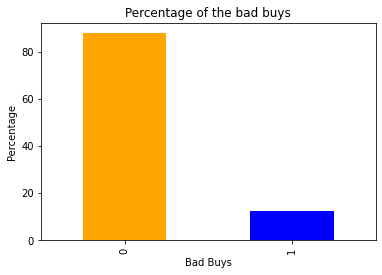

In [17]:
result=100 * y_train.value_counts() / len(y_train)
result.plot(kind="bar",color=['orange', 'blue'])
plt.title("Percentage of the bad buys")
plt.xlabel("Bad Buys")
plt.ylabel("Percentage")

Age of Vehicle with respect to the count of vehicles with the same age

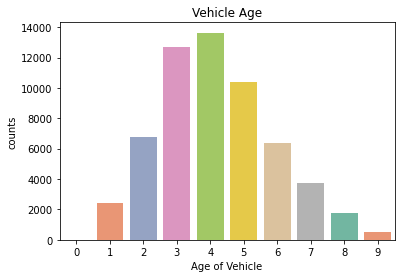

In [18]:
vehicle_age=pd.DataFrame(X_train.VehicleAge.value_counts())
plt.figure(figsize=(6,4))
sns.barplot(x=vehicle_age.index,y='VehicleAge',data=vehicle_age,palette='Set2')
plt.ylabel('counts')
plt.xlabel('Age of Vehicle')
plt.title("Vehicle Age")
plt.savefig('X_train vehicle_age bar graph', bbox_inches='tight')
plt.show()

# Imputing Null Values and Feature Engineering

Substituting the missing values of the numeric columns with the mean of the column

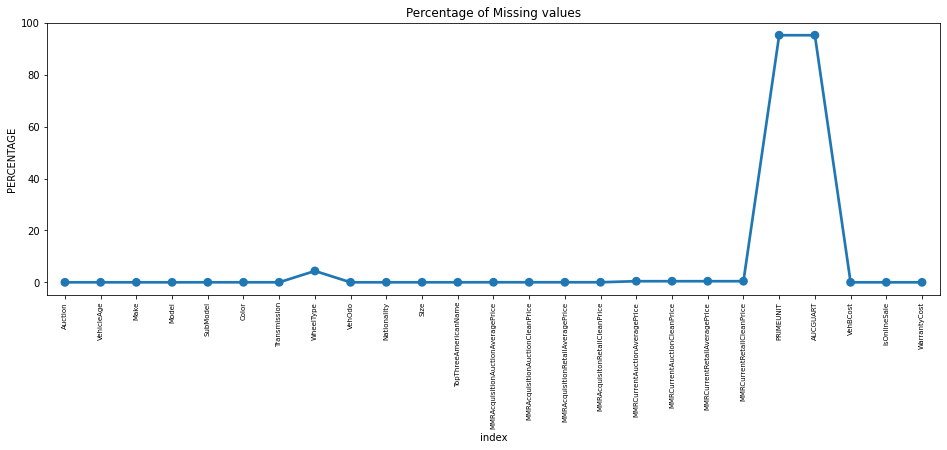

In [19]:
missing_data = pd.DataFrame( (X_train.isnull().sum()) * 100 / X_train.shape[0]).reset_index()
plt.figure(figsize = (16,5))
ax = sns.pointplot('index', 0, data = missing_data)
plt.xticks(rotation = 90, fontsize = 7)
plt.title('Percentage of Missing values')
plt.ylabel('PERCENTAGE')
plt.show()

In [20]:
#create dataframe with percentage of missing values
na = pd.DataFrame(X_train.isna().sum()) #
#removes columns with no missing values
na = na.loc[(na!=0).any(axis=1)]
#sort from the most to least missing values
na.sort_values(0, ascending=False)


,0
AUCGUART,55656
PRIMEUNIT,55656
WheelType,2556
MMRCurrentRetailCleanPrice,249
MMRCurrentRetailAveragePrice,249
MMRCurrentAuctionCleanPrice,249
MMRCurrentAuctionAveragePrice,249
MMRAcquisitionRetailAveragePrice,14
MMRAcquisitonRetailCleanPrice,14
MMRAcquisitionAuctionCleanPrice,14


In [21]:
imputer=SimpleImputer(strategy='mean');
imputer.fit(X_train[Train_numeric_cols]);
X_train[Train_numeric_cols]=imputer.transform(X_train[Train_numeric_cols])
X_test[Test_numeric_cols]=imputer.transform(X_test[Test_numeric_cols])

In [22]:
#for train

X_train.Color.fillna('Color_unk',inplace=True)
X_train.Transmission.fillna('Trans_unk',inplace=True)
X_train.WheelType.fillna('WheelType_unk',inplace=True)
X_train.Nationality.fillna('Nationality_unk',inplace=True)
X_train.Size.fillna('Size_unk',inplace=True)
X_train.SubModel.fillna('SubModel_unk',inplace=True)
X_train.TopThreeAmericanName.fillna('TopThreeAmericanName_unk',inplace=True)
X_train.PRIMEUNIT.fillna('PRIMEUNIT_unk',inplace=True)
X_train.AUCGUART.fillna('AUCGUART_unk',inplace=True)

#for test

X_test.Color.fillna('Color_unk',inplace=True)
X_test.Transmission.fillna('Trans_unk',inplace=True)
X_test.WheelType.fillna('WheelType_unk',inplace=True)
X_test.Nationality.fillna('Nationality_unk',inplace=True)
X_test.Size.fillna('Size_unk',inplace=True)
X_test.SubModel.fillna('SubModel_unk',inplace=True)
X_test.TopThreeAmericanName.fillna('TopThreeAmericanName_unk',inplace=True)
X_test.PRIMEUNIT.fillna('PRIMEUNIT_unk',inplace=True)
X_test.AUCGUART.fillna('AUCGUART_unk',inplace=True)

In [23]:
#create dataframe with percentage of missing values
after_impute_na = pd.DataFrame(X_train.isna().sum())
after_impute_na = after_impute_na.loc[(after_impute_na!=0).any(axis=1)]
after_impute_na.sort_values(0, ascending=False)

,0


In [24]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(sparse=False,handle_unknown='ignore')
encoder.fit(X_train[Train_categorical_cols])
encoded_cols=list(encoder.get_feature_names(Train_categorical_cols))
X_train[encoded_cols]=encoder.transform(X_train[Train_categorical_cols])
X_test[encoded_cols]=encoder.transform(X_test[Test_categorical_cols])

X_test=X_test[Test_numeric_cols+encoded_cols]
X_train=X_train[Train_numeric_cols+encoded_cols]

In [25]:
# Data Balancing using SMOTE OverSampling
from collections import Counter
from imblearn.over_sampling import SMOTE
counter = Counter(y_train)
print('Before', counter)
smt = SMOTE()
X_train, y_train = smt.fit_resample(X_train,y_train)
counter = Counter(y_train)
print('After', counter)

Before Counter({0: 51205, 1: 7181})
After Counter({0: 51205, 1: 51205})


# Modeling Without Feature Selection

In [26]:
Result = pd.DataFrame(columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"])
#Result = Result.astype({'Accuracy Score': np.float,'F1 Score': np.float,'Precision Score': np.float,'Recall Score': np.float,'AUC': np.float,'Kappa Score': np.float,})
Result.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Model            0 non-null      object
 1   Accuracy Score   0 non-null      object
 2   F1 Score         0 non-null      object
 3   Precision Score  0 non-null      object
 4   Recall Score     0 non-null      object
 5   AUC              0 non-null      object
 6   Kappa Score      0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


# Decision Tree

In [27]:
start=time.time()
tree=DecisionTreeClassifier(max_depth=12,random_state=42)
tree.fit(X_train, y_train)
stop=time.time()
dt_tt = round((stop-start) / 60, 2)
print(f"Training time: {dt_tt}min")

Training time: 0.2min


In [28]:
y_pred_dt = tree.predict(X_test)

In [29]:
#Confusion Matrix
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_dt),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12619,183
True[1],1403,392


In [30]:
#Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred_dt))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     12802
           1       0.68      0.22      0.33      1795

    accuracy                           0.89     14597
   macro avg       0.79      0.60      0.64     14597
weighted avg       0.87      0.89      0.87     14597



In [31]:
y_pred_p_dt = tree.predict_proba(X_test)
y_pred_p_dt = y_pred_p_dt[:, 1]
auc = roc_auc_score(y_test, y_pred_p_dt)

Accuracy=metrics.accuracy_score(y_test, y_pred_dt)
F1_Score=metrics.f1_score(y_test, y_pred_dt)
precision= metrics.precision_score(y_test, y_pred_dt)
recall=metrics.recall_score(y_test, y_pred_dt)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_dt)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 0, values=['Decision Tree',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8913475371651709
F1 Score: 0.3308016877637131
Precision Score: 0.6817391304347826
Recall Score: 0.21838440111420612
AUC: 70.10%
Kappa Score: 0.2883373336645083


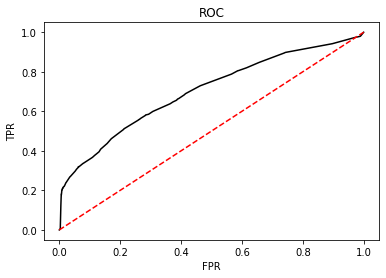

In [32]:
fpr,tpr,thresholds = roc_curve(y_test, tree.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('no feature selection decision tree roc', bbox_inches='tight')
plt.show()

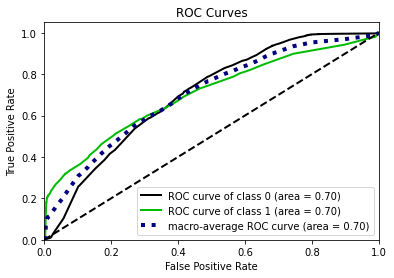

In [33]:
skplt.metrics.plot_roc(y_test, tree.predict_proba(X_test), plot_micro=False)
plt.savefig('no feature selection decision tree roc multiple', bbox_inches='tight')
plt.show()

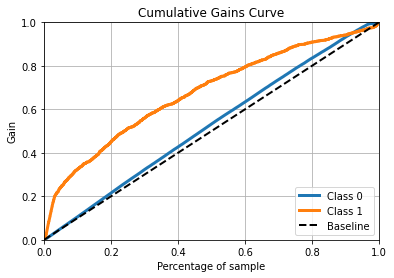

In [34]:
skplt.metrics.plot_cumulative_gain(y_test, tree.predict_proba(X_test))
plt.savefig('no feature selection decision tree cumulative gains curve', bbox_inches='tight')

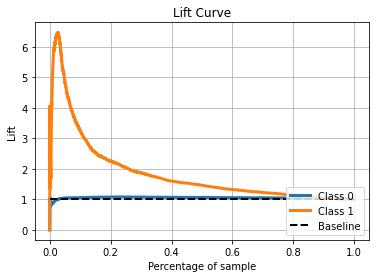

In [35]:
skplt.metrics.plot_lift_curve(y_test, tree.predict_proba(X_test))
plt.savefig('no feature selection decision tree lift curve', bbox_inches='tight')
plt.show()

# Random Forest

In [36]:
start=time.time()
forest = RandomForestClassifier( max_depth = 4, n_estimators = 500)
forest.fit(X_train, y_train)
stop=time.time()
rf_tt = round((stop-start) / 60, 2)
print(f"Training time: {rf_tt}min")

Training time: 0.82min


In [37]:
y_pred_rc = forest.predict(X_test)

In [38]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_rc),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],11509,1293
True[1],1235,560


In [39]:
#Classification Report
print('Classification Report of Random Forest Classifier')
print(classification_report(y_test, y_pred_rc))

Classification Report of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     12802
           1       0.30      0.31      0.31      1795

    accuracy                           0.83     14597
   macro avg       0.60      0.61      0.60     14597
weighted avg       0.83      0.83      0.83     14597



In [40]:
y_pred_p_rc = forest.predict_proba(X_test)
y_pred_p_rc = y_pred_p_rc[:, 1]
auc = roc_auc_score(y_test, y_pred_p_rc)

Accuracy=metrics.accuracy_score(y_test, y_pred_rc)
F1_Score=metrics.f1_score(y_test, y_pred_rc)
precision= metrics.precision_score(y_test, y_pred_rc)
recall=metrics.recall_score(y_test, y_pred_rc)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_rc)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 1, values=['Random Forest',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8268137288483935
F1 Score: 0.30701754385964913
Precision Score: 0.3022126281705343
Recall Score: 0.31197771587743733
AUC: 70.72%
Kappa Score: 0.20808738890465273


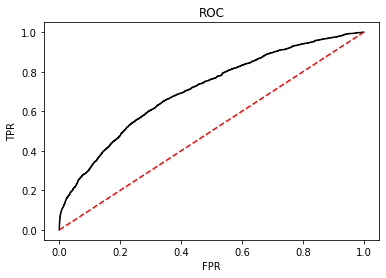

In [41]:
fpr,tpr,thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('no feature selection random forest roc', bbox_inches='tight')
plt.show()

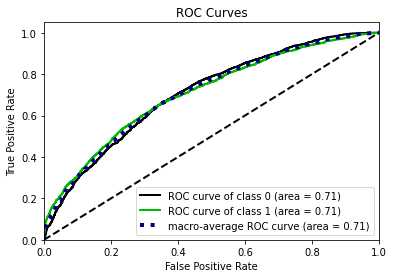

In [42]:
skplt.metrics.plot_roc(y_test, forest.predict_proba(X_test), plot_micro=False)
plt.savefig('no feature selection random forest roc multiple', bbox_inches='tight')

plt.show()

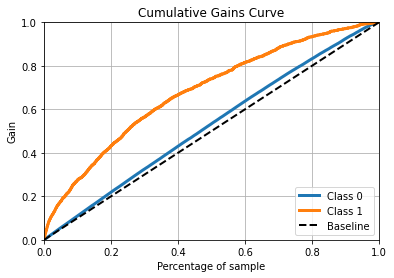

In [43]:
skplt.metrics.plot_cumulative_gain(y_test, forest.predict_proba(X_test))
plt.savefig('no feature selection random forest cumulative gains', bbox_inches='tight')

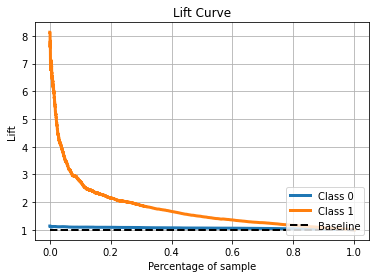

In [44]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(X_test))
plt.savefig('no feature selection random forest lift', bbox_inches='tight')

plt.show()

# Logistic Regression

In [45]:
start=time.time()
logistic = LogisticRegression(solver = 'liblinear', penalty = 'l2',C =0.001, random_state = 1)
logistic.fit(X_train, y_train)
stop=time.time()
lr_tt = round((stop-start) / 60, 2)
print(f"Training time: {lr_tt}min")

Training time: 0.12min


In [46]:
y_pred_lr = logistic.predict(X_test)

In [47]:
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_lr),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9528,3274
True[1],727,1068


In [48]:
#Classification Report
print('Classification Report of Logistic Regression')
print(classification_report(y_test, y_pred_lr))

Classification Report of Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.74      0.83     12802
           1       0.25      0.59      0.35      1795

    accuracy                           0.73     14597
   macro avg       0.59      0.67      0.59     14597
weighted avg       0.85      0.73      0.77     14597



In [49]:
y_pred_p_lr = logistic.predict_proba(X_test)
y_pred_p_lr = y_pred_p_lr[:, 1]
auc = roc_auc_score(y_test, y_pred_p_lr)


Accuracy=metrics.accuracy_score(y_test, y_pred_lr)
F1_Score=metrics.f1_score(y_test, y_pred_lr)
precision= metrics.precision_score(y_test, y_pred_lr)
recall=metrics.recall_score(y_test, y_pred_lr)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_lr)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 2, values=['Logistic Regression',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.7259025827224772
F1 Score: 0.3480527945250122
Precision Score: 0.24596959926301243
Recall Score: 0.5949860724233983
AUC: 73.52%
Kappa Score: 0.21071181587147148


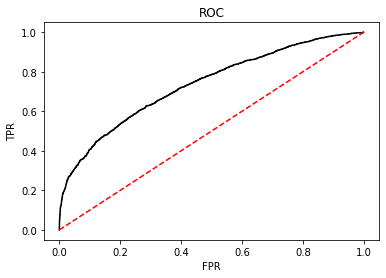

In [50]:
fpr,tpr,thresholds = roc_curve(y_test, logistic.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('no feature selection lr roc', bbox_inches='tight')
plt.show()

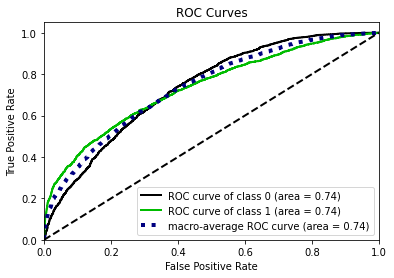

In [51]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(X_test), plot_micro=False)
plt.savefig('no feature selection lr roc multiple', bbox_inches='tight')
plt.show()

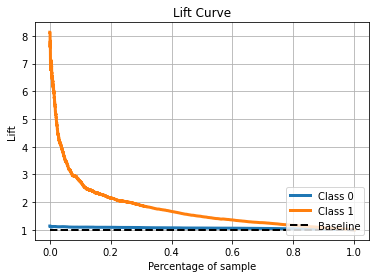

In [52]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(X_test))
plt.savefig('no feature selection lr lift', bbox_inches='tight')
plt.show()

# Naive Bayes Classifier

In [53]:
start=time.time()
gnb= GaussianNB(priors = [0.5,0.5])
gnb.fit(X_train, y_train)
stop=time.time()
nb_tt = round((stop-start) / 60, 2)
print(f"Training time: {nb_tt}min")

Training time: 0.09min


In [54]:
y_pred_gnb = gnb.predict(X_test)

In [55]:
y_pred_p_gnb = gnb.predict_proba(X_test)

In [56]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_gnb),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],4816,7986
True[1],302,1493


In [57]:
#Classification Report
print('Classification Report of Naive Bayes Classifier')
print(classification_report(y_test, y_pred_gnb))

Classification Report of Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.94      0.38      0.54     12802
           1       0.16      0.83      0.26      1795

    accuracy                           0.43     14597
   macro avg       0.55      0.60      0.40     14597
weighted avg       0.84      0.43      0.50     14597



In [58]:
y_pred_p_gnb = gnb.predict_proba(X_test)
y_pred_p_gnb = y_pred_p_gnb[:, 1]
auc = roc_auc_score(y_test, y_pred_p_gnb)

Accuracy=metrics.accuracy_score(y_test, y_pred_gnb)
F1_Score=metrics.f1_score(y_test, y_pred_gnb)
precision= metrics.precision_score(y_test, y_pred_gnb)
recall=metrics.recall_score(y_test, y_pred_gnb)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_gnb)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result = pd.DataFrame(np.insert(Result.values, 3, values=['Naive Bayes',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.4322120983763787
F1 Score: 0.2648571935426645
Precision Score: 0.1575060660407216
Recall Score: 0.8317548746518106
AUC: 67.25%
Kappa Score: 0.07321322186677404


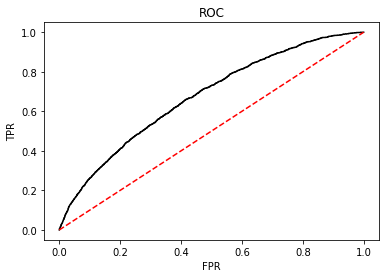

In [59]:
fpr,tpr,thresholds = roc_curve(y_test, gnb.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.savefig('no feature selection nb roc', bbox_inches='tight')
plt.show()

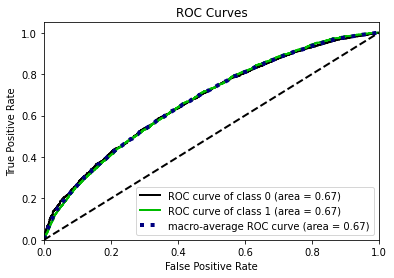

In [60]:
skplt.metrics.plot_roc(y_test, gnb.predict_proba(X_test), plot_micro=False)
plt.savefig('no feature selection nb roc multiple', bbox_inches='tight')
plt.show()

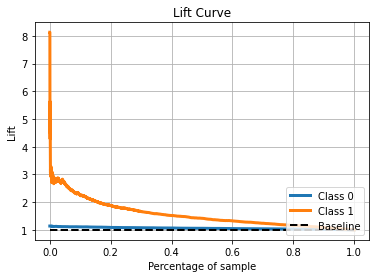

In [61]:
#####no cumulative gains for this one?
######export rest of figs
skplt.metrics.plot_lift_curve(y_test, gnb.predict_proba(X_test))
plt.savefig('no feature selection nb lift', bbox_inches='tight')
plt.show()

# Training Time of Models

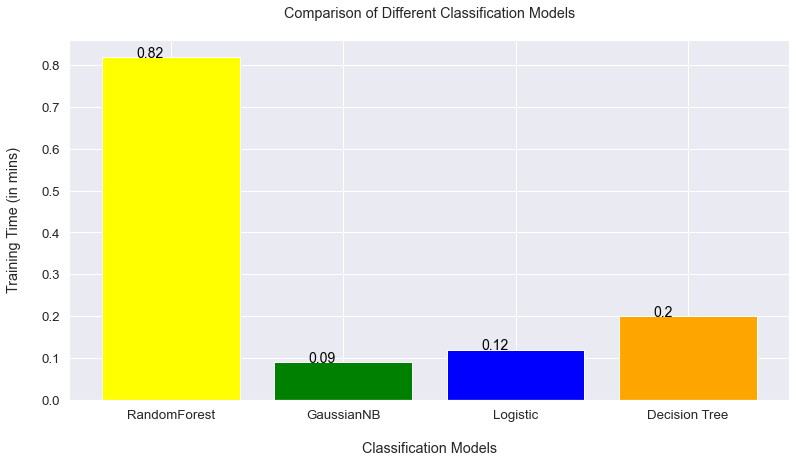

In [62]:
plt.rcParams["figure.figsize"] = (10,5)
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic','Decision Tree']
TrainingTime=[rf_tt,nb_tt,lr_tt,dt_tt]
ax.bar(Models,TrainingTime,color=["yellow","green", "blue","orange"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models\n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');
plt.show();

# Combined Results

In [63]:
Result.columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"]
Result

,Model,Accuracy Score,F1 Score,Precision Score,Recall Score,AUC,Kappa Score
0,Decision Tree,0.891348,0.330802,0.681739,0.218384,70.104034,0.288337
1,Random Forest,0.826814,0.307018,0.302213,0.311978,70.718738,0.208087
2,Logistic Regression,0.725903,0.348053,0.24597,0.594986,73.520058,0.210712
3,Naive Bayes,0.432212,0.264857,0.157506,0.831755,67.252719,0.073213


# ---------------------------------------------------------------------------------------------------------------

# Modeling With Feature Selection

# Feature Selection

Chi2 k Best features

In [64]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
bestfeatures=SelectKBest(score_func=chi2,k=100)
fit=bestfeatures.fit(X_train, y_train)
dfscores=pd.DataFrame(fit.scores_)
dfcolumns=pd.DataFrame(X_train.columns)
featurescores=pd.concat([dfcolumns,dfscores],axis=1)
featurescores.to_csv('Support_Features_CHI2.csv')
featurescores.columns=["features","scores"]

In [65]:
print(featurescores.nlargest(50,'scores'))

                               features        scores
1                                VehOdo  4.827510e+06
2     MMRAcquisitionAuctionAveragePrice  2.955591e+06
8          MMRCurrentRetailAveragePrice  2.942979e+06
6         MMRCurrentAuctionAveragePrice  2.854070e+06
9            MMRCurrentRetailCleanPrice  2.751933e+06
3       MMRAcquisitionAuctionCleanPrice  2.646875e+06
7           MMRCurrentAuctionCleanPrice  2.614883e+06
4      MMRAcquisitionRetailAveragePrice  2.183426e+06
5         MMRAcquisitonRetailCleanPrice  2.011196e+06
10                             VehBCost  1.202483e+06
12                         WarrantyCost  1.227909e+05
1955            WheelType_WheelType_unk  1.138871e+04
0                            VehicleAge  4.174101e+03
1953                   WheelType_Covers  2.333875e+03
1979                       PRIMEUNIT_NO  1.099313e+03
1983                     AUCGUART_GREEN  1.093623e+03
1975          TopThreeAmericanName_FORD  4.447460e+02
1377          SubModel_4D SE

Random forest

In [66]:
sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

<AxesSubplot:>

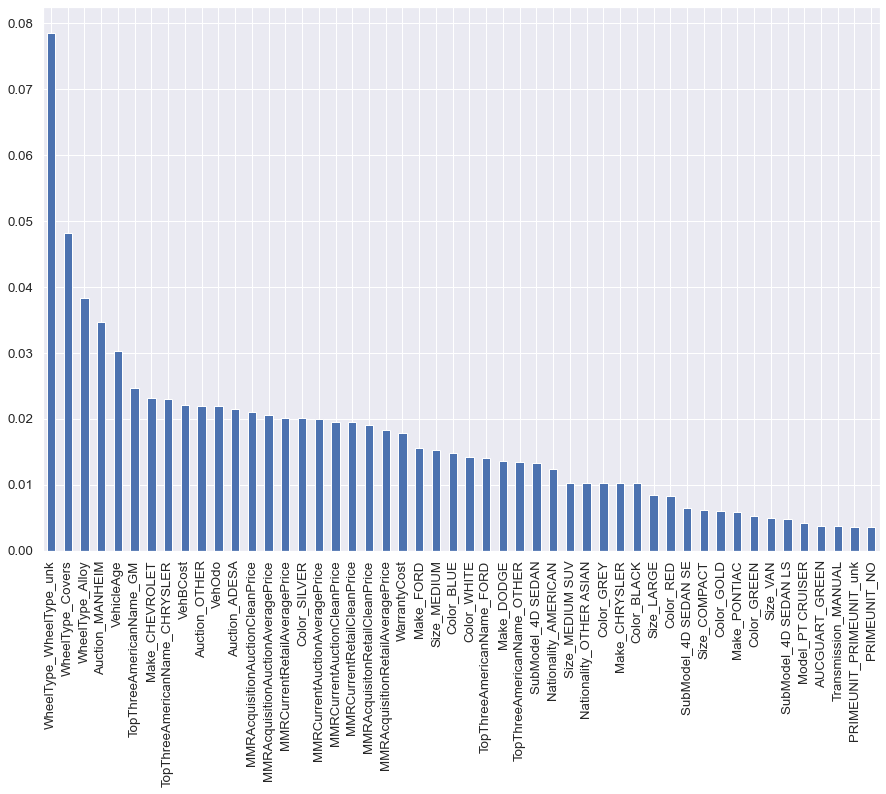

In [67]:
#Feature Importance
plt.rcParams["figure.figsize"] = (15,10)
feat_importances = pd.Series(sel.estimator_.feature_importances_ , index= X_train.columns)
feat_importances.nlargest(50).plot(kind='bar')

In [68]:
sel_array = pd.Series(sel.get_support(), name='bools')
selected_feat = pd.DataFrame(feat_importances)
selected_feat = selected_feat[sel_array.values]


In [69]:
unique, counts = np.unique(sel_array, return_counts=True)
print(unique[0],":",counts[0])
print(unique[1],":",counts[1])

False : 1871
True : 114


In [70]:
selected_feat.rename(columns = {0:'Support'}, inplace = True)
selected_feat = selected_feat.sort_values('Support', ascending=False)
selected_feat.to_csv('Support_Features_RF.csv')
selected_feat
print("Selected features :", selected_feat)

Selected features :                              Support
WheelType_WheelType_unk     0.078541
WheelType_Covers            0.048189
WheelType_Alloy             0.038309
Auction_MANHEIM             0.034676
VehicleAge                  0.030324
...                              ...
Model_STRATUS V6 2.7L V6 M  0.000534
SubModel_4D SEDAN LIMITED   0.000527
Model_PACIFICA FWD          0.000526
Model_MALIBU 4C 2.2L I4 MP  0.000522
SubModel_4D SEDAN LT 3.5L   0.000517

[114 rows x 1 columns]


In [71]:
train_new = X_train[selected_feat.index]
test_new=X_test[selected_feat.index]

In [72]:
Result_new = pd.DataFrame(columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"])
Result_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Model            0 non-null      object
 1   Accuracy Score   0 non-null      object
 2   F1 Score         0 non-null      object
 3   Precision Score  0 non-null      object
 4   Recall Score     0 non-null      object
 5   AUC              0 non-null      object
 6   Kappa Score      0 non-null      object
dtypes: object(7)
memory usage: 0.0+ bytes


# Decision Tree

In [73]:
start=time.time()
tree=DecisionTreeClassifier(max_depth=12,random_state=42)
tree.fit(train_new, y_train)
stop=time.time()
dt_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {dt_tt_new}min")

Training time: 0.04min


In [74]:
y_pred_dt_new = tree.predict(test_new)

In [75]:
#Confusion Matrix
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_dt_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],12604,198
True[1],1405,390


In [76]:
#Classification Report
print('Classification Report')
print(classification_report(y_test, y_pred_dt_new))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12802
           1       0.66      0.22      0.33      1795

    accuracy                           0.89     14597
   macro avg       0.78      0.60      0.63     14597
weighted avg       0.87      0.89      0.86     14597



In [77]:
y_pred_p_dt_new = tree.predict_proba(test_new)
y_pred_p_dt_new = y_pred_p_dt_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_dt_new)

Accuracy=metrics.accuracy_score(y_test, y_pred_dt_new)
F1_Score=metrics.f1_score(y_test, y_pred_dt_new)
precision= metrics.precision_score(y_test, y_pred_dt_new)
recall=metrics.recall_score(y_test, y_pred_dt_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_dt_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 0, values=['Decision Tree',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8901829142974583
F1 Score: 0.32731850608476704
Precision Score: 0.6632653061224489
Recall Score: 0.21727019498607242
AUC: 70.24%
Kappa Score: 0.2838592262389624


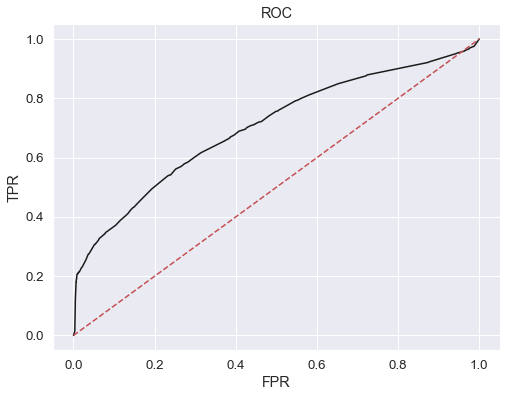

In [78]:
plt.rcParams["figure.figsize"] = (8,6)
fpr,tpr,thresholds = roc_curve(y_test, tree.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

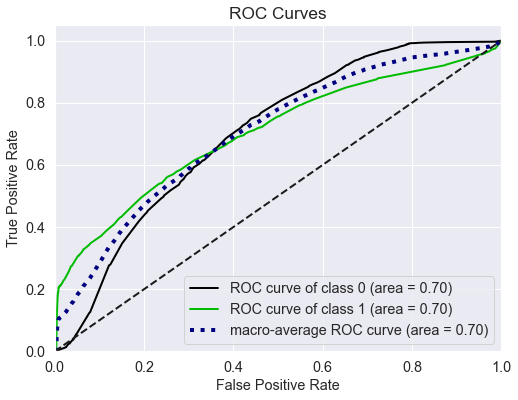

In [79]:
skplt.metrics.plot_roc(y_test, tree.predict_proba(test_new), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

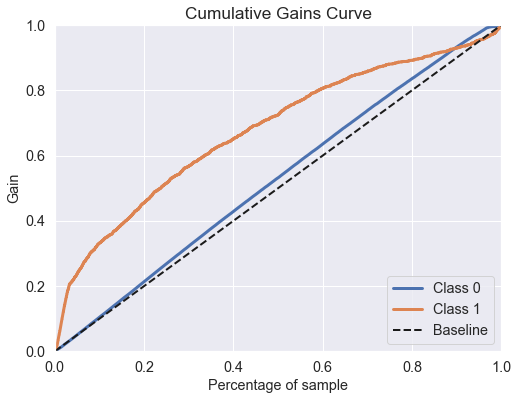

In [80]:
skplt.metrics.plot_cumulative_gain(y_test, tree.predict_proba(test_new))

# Random Forest Classifier

In [81]:
start=time.time()
forest = RandomForestClassifier( max_depth = 4, n_estimators = 500)
forest.fit(train_new, y_train)
stop=time.time()
rf_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {rf_tt_new}min")

Training time: 0.8min


In [82]:
y_pred_rc_new = forest.predict(test_new)

In [83]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_rc_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],12501,301
True[1],1333,462


In [84]:
#Classification Report
print('Classification Report of Random Forest Classifier')
print(classification_report(y_test, y_pred_rc_new))

Classification Report of Random Forest Classifier
              precision    recall  f1-score   support

           0       0.90      0.98      0.94     12802
           1       0.61      0.26      0.36      1795

    accuracy                           0.89     14597
   macro avg       0.75      0.62      0.65     14597
weighted avg       0.87      0.89      0.87     14597



In [85]:
y_pred_p_rc_new = forest.predict_proba(test_new)
y_pred_p_rc_new = y_pred_p_rc_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_rc_new)

Accuracy=metrics.accuracy_score(y_test, y_pred_rc_new)
F1_Score=metrics.f1_score(y_test, y_pred_rc_new)
precision= metrics.precision_score(y_test, y_pred_rc_new)
recall=metrics.recall_score(y_test, y_pred_rc_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_rc_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 1, values=['Random Forest',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.8880591902445708
F1 Score: 0.361219702892885
Precision Score: 0.6055045871559633
Recall Score: 0.2573816155988858
AUC: 71.72%
Kappa Score: 0.3106494701900777


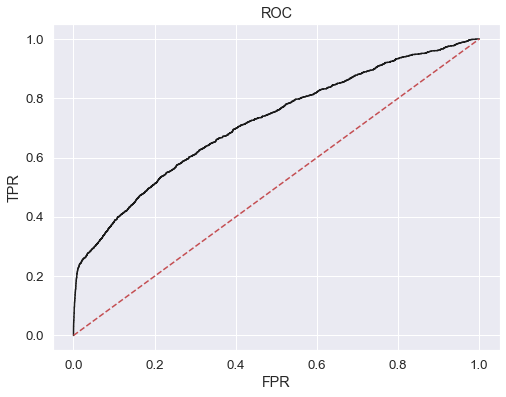

In [86]:
fpr,tpr,thresholds = roc_curve(y_test, forest.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

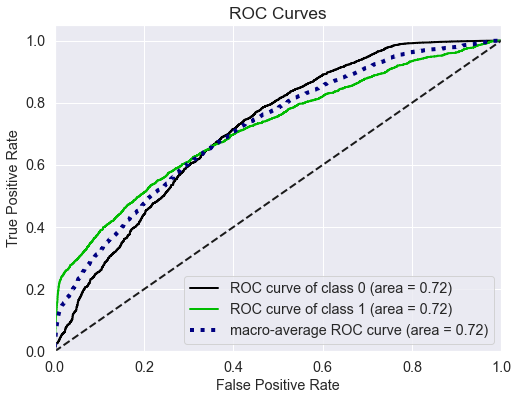

In [87]:
skplt.metrics.plot_roc(y_test, forest.predict_proba(test_new), plot_micro=False)
plt.show()

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

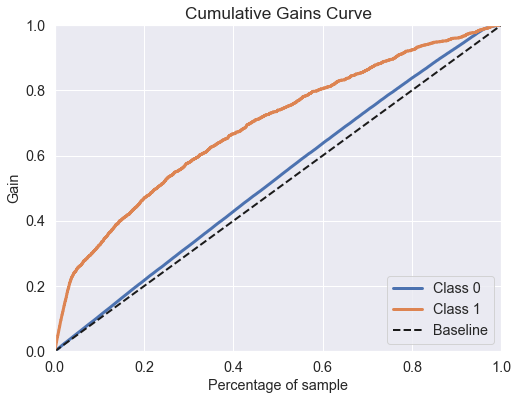

In [88]:
skplt.metrics.plot_cumulative_gain(y_test, forest.predict_proba(test_new))

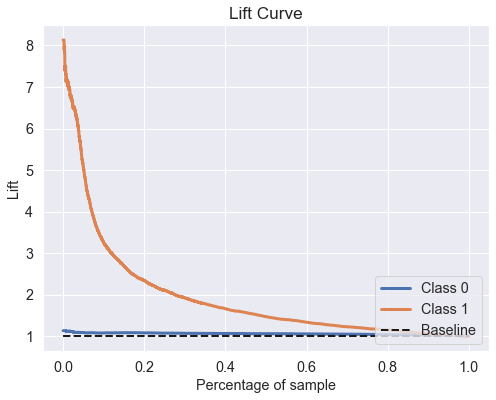

In [89]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(test_new))
plt.show()

# Logistic Regression

In [90]:
start=time.time()
logistic = LogisticRegression(solver = 'liblinear', penalty = 'l2',C =0.001, random_state = 1)
logistic.fit(train_new, y_train)
stop=time.time()
lr_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {lr_tt_new}min")

Training time: 0.07min


In [91]:
y_pred_lr_new = logistic.predict(test_new)

In [92]:
confmat = pd.DataFrame(confusion_matrix(y_test,y_pred_lr_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat

,Predict[0],Predict[1]
True[0],9889,2913
True[1],763,1032


In [93]:
#Classification Report
print('Classification Report of Logistic Regression')
print(classification_report(y_test, y_pred_lr_new))

Classification Report of Logistic Regression
              precision    recall  f1-score   support

           0       0.93      0.77      0.84     12802
           1       0.26      0.57      0.36      1795

    accuracy                           0.75     14597
   macro avg       0.59      0.67      0.60     14597
weighted avg       0.85      0.75      0.78     14597



In [94]:
y_pred_p_lr_new = logistic.predict_proba(test_new)
y_pred_p_lr_new = y_pred_p_lr_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_lr_new)


Accuracy=metrics.accuracy_score(y_test, y_pred_lr_new)
F1_Score=metrics.f1_score(y_test, y_pred_lr_new)
precision= metrics.precision_score(y_test, y_pred_lr_new)
recall=metrics.recall_score(y_test, y_pred_lr_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_lr_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 2, values=['Logistic Regression',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.7481674316640405
F1 Score: 0.3595818815331011
Precision Score: 0.26159695817490497
Recall Score: 0.5749303621169917
AUC: 74.27%
Kappa Score: 0.2293118071108291


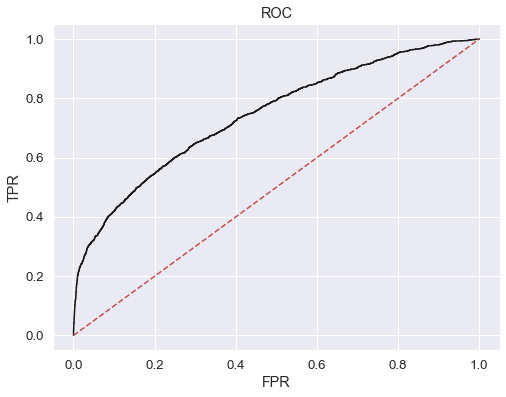

In [95]:
fpr,tpr,thresholds = roc_curve(y_test, logistic.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

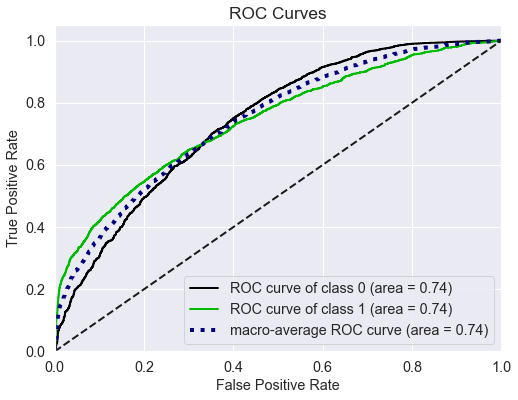

In [96]:
skplt.metrics.plot_roc(y_test, logistic.predict_proba(test_new), plot_micro=False)
plt.show()

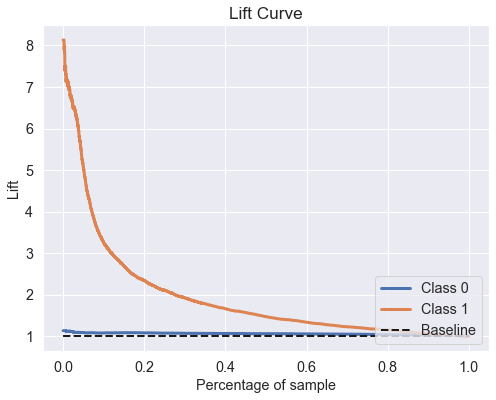

In [97]:
skplt.metrics.plot_lift_curve(y_test, forest.predict_proba(test_new))
plt.show()

# Naive Bayes

In [98]:
start=time.time()
gnb= GaussianNB(priors = [0.5,0.5])
gnb.fit(train_new, y_train)
stop=time.time()
nb_tt_new = round((stop-start) / 60, 2)
print(f"Training time: {nb_tt_new}min")

Training time: 0.0min


In [99]:
y_pred_gnb_new = gnb.predict(test_new)

In [100]:
#Confusion Matrix
confmat_forest = pd.DataFrame(confusion_matrix(y_test,y_pred_gnb_new),
                index = ['True[0]','True[1]'],
                columns = ['Predict[0]', 'Predict[1]'])
confmat_forest

,Predict[0],Predict[1]
True[0],5939,6863
True[1],435,1360


In [101]:
#Classification Report
print('Classification Report of Naive Bayes Classifier')
print(classification_report(y_test, y_pred_gnb_new))

Classification Report of Naive Bayes Classifier
              precision    recall  f1-score   support

           0       0.93      0.46      0.62     12802
           1       0.17      0.76      0.27      1795

    accuracy                           0.50     14597
   macro avg       0.55      0.61      0.45     14597
weighted avg       0.84      0.50      0.58     14597



In [102]:
y_pred_p_gnb_new = gnb.predict_proba(test_new)
y_pred_p_gnb_new = y_pred_p_gnb_new[:, 1]
auc = roc_auc_score(y_test, y_pred_p_gnb)

Accuracy=metrics.accuracy_score(y_test, y_pred_gnb_new)
F1_Score=metrics.f1_score(y_test, y_pred_gnb_new)
precision= metrics.precision_score(y_test, y_pred_gnb_new)
recall=metrics.recall_score(y_test, y_pred_gnb_new)
auc=(auc*100)
kappa_score=metrics.cohen_kappa_score(y_test, y_pred_gnb_new)

print('\033[1m'+"Accuracy Score:"+ '\033[0m',Accuracy) 
print('\033[1m'+"F1 Score:"+ '\033[0m',F1_Score)
print('\033[1m'+"Precision Score:"+ '\033[0m',precision)
print('\033[1m'+"Recall Score:"+ '\033[0m',recall)
print('\033[1m'+'AUC:'+ '\033[0m' ' %.2f%%' % (auc))
print('\033[1m'+"Kappa Score:"+ '\033[0m',kappa_score)
Result_new = pd.DataFrame(np.insert(Result_new.values, 3, values=['Naive Bayes',Accuracy,F1_Score,precision,recall,auc,kappa_score], axis=0))

Accuracy Score: 0.5000342536137562
F1 Score: 0.2715112796965462
Precision Score: 0.1653897604280676
Recall Score: 0.7576601671309192
AUC: 67.25%
Kappa Score: 0.08725113650524352


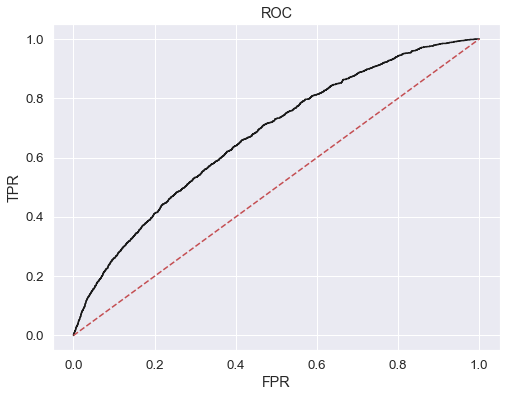

In [103]:
fpr,tpr,thresholds = roc_curve(y_test, gnb.predict_proba(test_new)[:,1])
plt.plot(fpr,tpr,'k')
plt.plot([0,1],[0,1],'r--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC')
plt.show()

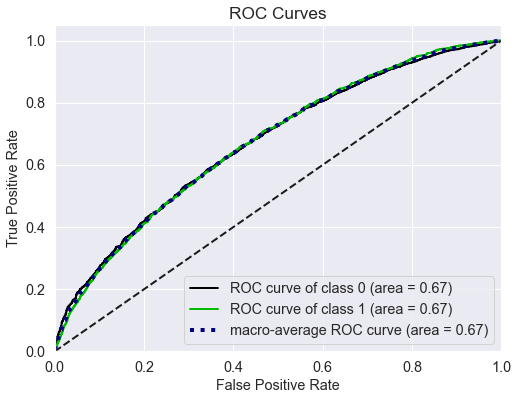

In [104]:
skplt.metrics.plot_roc(y_test, gnb.predict_proba(test_new), plot_micro=False)
plt.show()

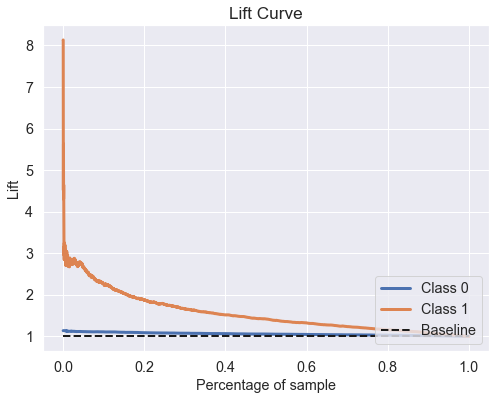

In [105]:
skplt.metrics.plot_lift_curve(y_test, gnb.predict_proba(test_new))
plt.show()

# Training Time of Models With Feature Selection

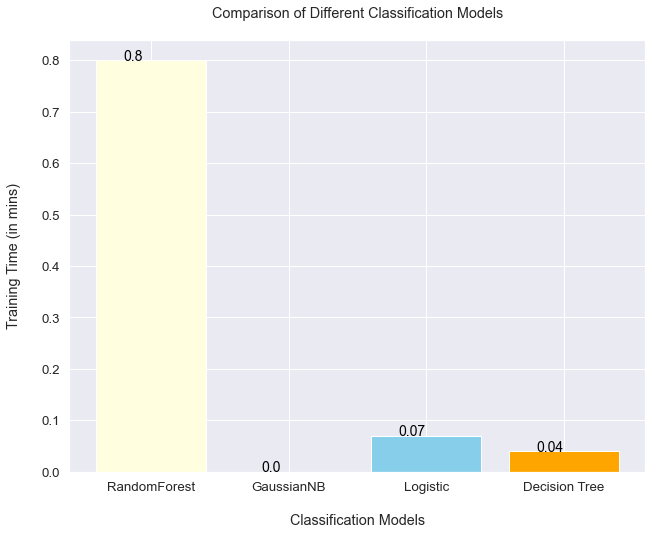

In [106]:
sns.set(font_scale=1.2)
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
Models = ['RandomForest', 'GaussianNB', 'Logistic','Decision Tree']
TrainingTime=[rf_tt_new,nb_tt_new,lr_tt_new,dt_tt_new]
ax.bar(Models,TrainingTime,color=["lightyellow","lightgreen", "skyblue","orange"]);
for i in ax.patches:
    ax.text(i.get_x()+.2, i.get_height(), str(round(i.get_height(),2)), fontsize=14, color='black')
plt.title('Comparison of Different Classification Models\n');
plt.ylabel('Training Time (in mins)\n');
plt.xlabel('\nClassification Models');
plt.show();

# Combined Results With Feature Selection

In [107]:
Result_new.columns = ["Model","Accuracy Score", "F1 Score","Precision Score","Recall Score","AUC","Kappa Score"]
Result_new

,Model,Accuracy Score,F1 Score,Precision Score,Recall Score,AUC,Kappa Score
0,Decision Tree,0.890183,0.327319,0.663265,0.21727,70.240835,0.283859
1,Random Forest,0.888059,0.36122,0.605505,0.257382,71.721338,0.310649
2,Logistic Regression,0.748167,0.359582,0.261597,0.57493,74.267874,0.229312
3,Naive Bayes,0.500034,0.271511,0.16539,0.75766,67.252719,0.087251
